2-7-24

This is the record of attempts to take the first corpus, 1.0. and train a model on the embeddings created from it.



In [2]:
import sentencepiece as spm
from tqdm import tqdm
import os

input_file = "Juliet2_corpus.txt"
output_model_prefix = "m"
vocab_size = 15000
model_type = "bpe"

def preprocess(input_file):
    try:
        with open(input_file, "r", encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
        return None

    # Preprocessing steps
    text = text.replace(" ", " SPACE")
    text = text.replace("\n", " NEWLINE")
    text = text.replace("\t", " TAB")

    temp_input_file = input_file + ".preprocessed"
    try:
        with open(temp_input_file, 'w', encoding='utf-8') as file:
            file.write(text)
    except OSError as e:
        print(f"Error writing preprocessed file: {e}")
        return None

    return temp_input_file

def train_tokenizer(input_file, output_model_prefix, vocab_size, model_type):
    tqdm.write("Training tokenizer:")
    try:
        spm.SentencePieceTrainer.train(
            input=input_file,
            model_prefix=output_model_prefix,
            vocab_size=vocab_size,
            model_type=model_type,
            num_threads=4,  # Set the number of threads for parallel processing during training
            # Other training parameters as needed
        )
    except Exception as e:
        print(f"Error training tokenizer: {e}")
        return

    tqdm.write("Training complete.")

# Iterate training for the specified number of iterations:
temp_input_file = preprocess(input_file)
if temp_input_file:
    train_tokenizer(temp_input_file, output_model_prefix, vocab_size, model_type)
    # Load the trained model
    sp = spm.SentencePieceProcessor()
    sp.Load(f"{output_model_prefix}.model")
else:
    print("Preprocessing failed. Cannot train tokenizer.")


Error: Input file 'Juliet2_corpus.txt' not found.
Preprocessing failed. Cannot train tokenizer.


In [25]:
def test_tokenizer(tokenizer, test_lines):
    correct_tokenizations = 0
    total_tokenizations = len(test_lines)

    for line in test_lines:
        # Assuming test_lines is a list of source code lines
        original_line = line.strip()
        
        # Tokenize the line using the trained tokenizer
        tokenized_line = tokenizer.encode(original_line)

        # Decode the tokenized line back to text
        decoded_line = tokenizer.decode(tokenized_line)

        # Check if the decoded line matches the original line
        if decoded_line.strip() == original_line:
            correct_tokenizations += 1

        total_tokenizations += 1

    accuracy = correct_tokenizations / total_tokenizations
    print(f"Total lines: {total_tokenizations}")
    print(f"Tokenization Accuracy: {accuracy * 100:.2f}%")

# Example usage


# Train the tokenizer with progress bar

test_file = "Juliet2_TEST.txt"

with open(test_file, 'r', encoding='utf-8') as file:
    test_lines = file.readlines()

# Test the tokenizer
tqdm.write("Starting tokenizer test:")
test_tokenizer(sp, test_lines)
tqdm.write("Tokenizer test complete.")

Starting tokenizer test:
Total lines: 4876180
Tokenization Accuracy: 49.58%
Tokenizer test complete.


### Picking up with the aiXcoder=7B model

Fortunately for me, I stumbled across a rising repository that is pruports to be a foundational model for Code. If this is the case, I would imagine that it would get a 90+ precent tokenization accuracy on my raw Juliet sentences. There are also some positional sequenceing work done with some (ROPE) and transformer architecture that I am only partially familar with. For now I just want to see how well it generally tokenizes wild code. 

<br>
4-14-24 TEST 1<br>
RESULTS: 100% Tokenization Rate in 70 seconds on the Juliet Raw corpus <br>
DEPENDENCES: trying to incorporate the aiXcoder-7B straight from its Hugging Face transformers library, and hope that it plays nice with what I have here because I really want to use it on the fly here. If not I can also start totally clean with a docker image. <br>


Starting model test:


Tokenizing: 100%|██████████| 12604386/12604386 [01:10<00:00, 178111.50it/s]


Total lines: 12604386
Tokenization Accuracy: 100.00%


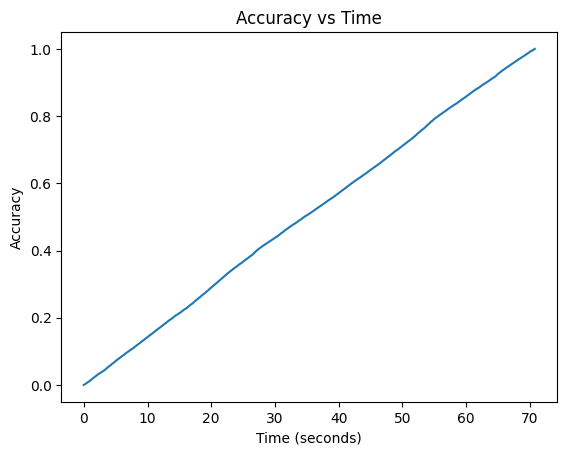

Model test complete.


In [7]:
import sentencepiece as spm
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Load SentencePiece model from local file
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')

def test_model(sp, test_lines):
    correct_tokenizations = 0
    total_tokenizations = len(test_lines)
    accuracies = []
    times = []
    start_time = time.time()

    for line in tqdm(test_lines, desc="Tokenizing"):
        # Assuming test_lines is a list of source code lines
        original_line = line.strip()
        
        # Tokenize the line using the SentencePiece model
        tokenized_line = sp.EncodeAsPieces(original_line)

        # Decode the tokenized line back to text
        decoded_line = ''.join(tokenized_line).replace('▁', ' ')

        # Check if the decoded line matches the original line
        if decoded_line.strip() == original_line:
            correct_tokenizations += 1

        # Calculate accuracy and elapsed time and append to lists
        accuracy = correct_tokenizations / (total_tokenizations + 1)
        accuracies.append(accuracy)
        times.append(time.time() - start_time)

    print(f"Total lines: {total_tokenizations}")
    print(f"Tokenization Accuracy: {accuracy * 100:.2f}%")

    # Plot accuracy versus time
    plt.plot(times, accuracies)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Time')
    plt.show()

# Example usage
with open('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\Juliet2_Corpus.txt', 'r') as f:
    lines = f.readlines()

# Test the model
print("Starting model test:")
test_model(sp, lines)
print("Model test complete.")

Sanity check against english sentences. 

Starting model test:


Tokenizing: 100%|██████████| 20000/20000 [00:00<00:00, 145983.28it/s]

Total lines: 20000
Tokenization Accuracy: 100.00%


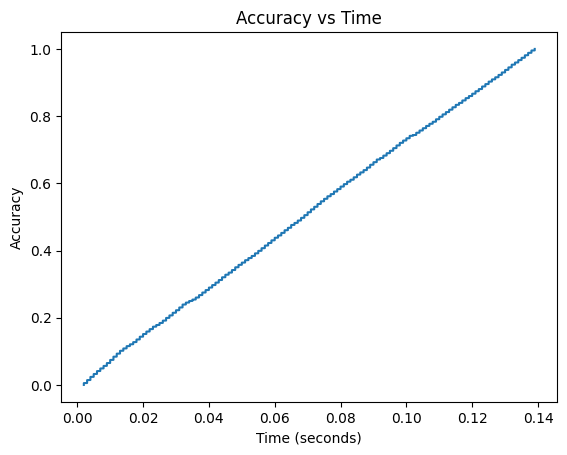

Model test complete.


In [9]:
# Example usage
with open('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\eng_sentences.txt', 'r') as f:
    lines = f.readlines()

# Test the model
print("Starting model test:")
test_model(sp, lines)
print("Model test complete.")

Will it perform the same on French Sentences?

Starting model test:


Tokenizing: 100%|██████████| 20000/20000 [00:00<00:00, 80971.74it/s]


Total lines: 20000
Tokenization Accuracy: 100.00%


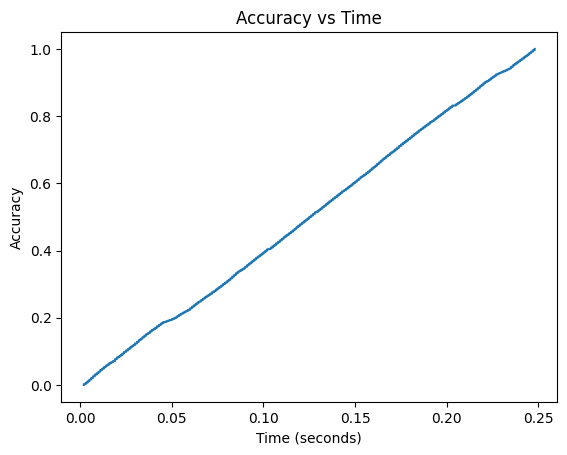

Model test complete.


In [11]:
with open('C:\\Users\\Andrew\\Desktop\\nasa_project\\Juliet\\Large Files\\output_sentences.txt', 'r') as f:
    lines = f.readlines()

# Test the model
print("Starting model test:")
test_model(sp, lines)
print("Model test complete.")